# MobileNetV3 Finetuning with Cats vs Dogs dataset

In [1]:
# --- 🔥 Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import os
import copy
import random
import pandas as pd

In [2]:
# --- ⚙️ Config ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

batch_size = 32
learning_rate = 1e-4
num_epochs = 50
early_stopping_patience = 5

Usando dispositivo: cuda


In [3]:
# --- 🖼️ Transformations ---
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# --- 🗂️ Load the dataset ---
dataset_path = '../../dataset'  # donde guardaste las imágenes

full_dataset = datasets.ImageFolder(dataset_path, transform=train_transforms)

In [5]:
# --- 🎯 Filter paths ---
cat_paths = [path for path, label in full_dataset.samples if label == 0]
dog_paths = [path for path, label in full_dataset.samples if label == 1]

random.shuffle(cat_paths)
random.shuffle(dog_paths)

selected_cat_paths = cat_paths[:2000]
selected_dog_paths = dog_paths[:2000]

# Paths usados para train/val
selected_paths = selected_cat_paths + selected_dog_paths

# Paths para test (no usados)
test_cat_paths = cat_paths[2000:]
test_dog_paths = dog_paths[2000:]


In [6]:
# --- ✂️ Divide training and validation ---
random.shuffle(selected_paths)

train_size = int(0.8 * len(selected_paths))  # 80%
val_size = len(selected_paths) - train_size  # 20%

train_paths = selected_paths[:train_size]
val_paths = selected_paths[train_size:]

In [7]:
# --- 📝 Create dataframe to export ---
records = []

for path in train_paths:
    label = 'cat' if 'cat' in os.path.basename(path) else 'dog'
    records.append({'image': path, 'class': label, 'type': 'training'})

for path in val_paths:
    label = 'cat' if 'cat' in os.path.basename(path) else 'dog'
    records.append({'image': path, 'class': label, 'type': 'validation'})

for path in test_cat_paths + test_dog_paths:
    label = 'cat' if 'cat' in os.path.basename(path) else 'dog'
    records.append({'image': path, 'class': label, 'type': 'test'})

df = pd.DataFrame(records)

# Save the CSV
os.makedirs('../../csv', exist_ok=True)
df.to_csv('../../csv/training_images.csv', index=False)

print(f"✅ CSV created with {len(df)} entries in '../../csv/training_images.csv'")


✅ CSV created with 23410 entries in '../../csv/training_images.csv'


In [8]:
# --- 📋 Create Subsets for training and validation ---
# Crate index to path
path_to_index = {path: idx for idx, (path, _) in enumerate(full_dataset.samples)}

train_indices = [path_to_index[path] for path in train_paths]
val_indices = [path_to_index[path] for path in val_paths]

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Change the transform for the validation dataset
val_dataset.dataset.transform = val_test_transforms

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# --- 🏗️ Load the pretrained MobileNetV3 model ---
model = models.mobilenet_v3_large(pretrained=True)

# Replace the last layer
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 2)
model = model.to(device)


/home/juancarlos/Documents/dev/vision/cats_vs_dogs_parallel_inference/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juancarlos/Documents/dev/vision/cats_vs_dogs_parallel_inference/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# --- ⚡ Define loss and optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# --- 🛑 Early stopping helper ---
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.best_epoch = None  # 👈 guardamos la mejor epoch

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_epoch = epoch  # 👈 actualizamos la best epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=early_stopping_patience)

In [11]:
import matplotlib.pyplot as plt

# --- Getting things ready to plot the training results ---
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [12]:
# --- 🔥 Training loop ---
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    early_stopping(val_loss, model, epoch)

    if early_stopping.early_stop:
        print("🛑 Early stopping triggered!")
        break


Epoch [1/50], Train Loss: 0.1839, Train Acc: 0.9309, Val Loss: 0.0538, Val Acc: 0.9800
Epoch [2/50], Train Loss: 0.0327, Train Acc: 0.9903, Val Loss: 0.0540, Val Acc: 0.9825
Epoch [3/50], Train Loss: 0.0122, Train Acc: 0.9969, Val Loss: 0.0467, Val Acc: 0.9888
Epoch [4/50], Train Loss: 0.0071, Train Acc: 0.9981, Val Loss: 0.0582, Val Acc: 0.9825
Epoch [5/50], Train Loss: 0.0052, Train Acc: 0.9984, Val Loss: 0.0536, Val Acc: 0.9875
Epoch [6/50], Train Loss: 0.0033, Train Acc: 0.9994, Val Loss: 0.0622, Val Acc: 0.9838
Epoch [7/50], Train Loss: 0.0056, Train Acc: 0.9978, Val Loss: 0.0815, Val Acc: 0.9750
Epoch [8/50], Train Loss: 0.0101, Train Acc: 0.9962, Val Loss: 0.0597, Val Acc: 0.9800
🛑 Early stopping triggered!


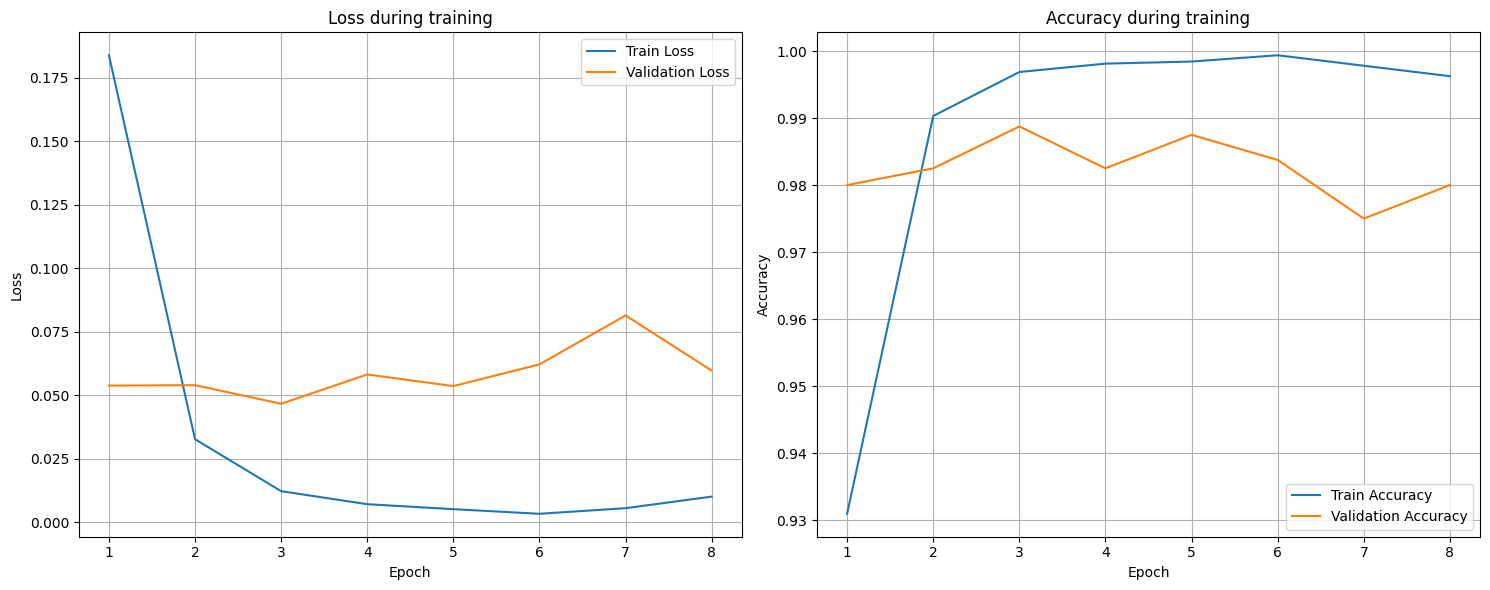

In [13]:
# --- 📈 Plot the traininig evolution ---

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15,6))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.grid()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during training')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [15]:
# --- 💾 Get the best model and save ---
model.load_state_dict(early_stopping.best_model)

directory = '../../model'

os.makedirs(directory, exist_ok=True)
torch.save(model.state_dict(), directory+'/mobilenetv3_cats_vs_dogs.pth')
print(f"✅ Model saved in '{directory}/mobilenetv3_cats_vs_dogs.pth'")

✅ Model saved in '../../model/mobilenetv3_cats_vs_dogs.pth'
